# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `<05>`
* Students: `<Wentao Feng, Yunbei Wang, Yan Fu, Zhaodong Sun>`
* Dataset: `<Flight route>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [2]:
routes = pd.read_csv("routes.dat", names = ['Airline', 'Airline_ID', 'S_Port', 'S_ID', 
                                            'D_Port', 'D_ID', 'Codeshare', 'Stops', 'Equipment'])
# S_Port*D_Port = 3407*3448

airlines = pd.read_csv("airlines.dat",names = ['Airline_ID','Name','Alias','IATA','ICAO','Callsign','Country','Active'])

airports = pd.read_csv("airports.txt",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'])
#S stands for source; D stands for destination

In [3]:
routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 9 columns):
Airline       67663 non-null object
Airline_ID    67663 non-null object
S_Port        67663 non-null object
S_ID          67663 non-null object
D_Port        67663 non-null object
D_ID          67663 non-null object
Codeshare     14597 non-null object
Stops         67663 non-null int64
Equipment     67645 non-null object
dtypes: int64(1), object(8)
memory usage: 4.6+ MB


In [4]:
port1 = pd.concat([routes.S_Port,routes.D_Port],axis=0).drop_duplicates()#.sort_values().get_values()
port1.shape

(3425,)

In [5]:
routes.D_Port.drop_duplicates().shape

(3418,)

In [6]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6162 entries, 0 to 6161
Data columns (total 8 columns):
Airline_ID    6162 non-null int64
Name          6162 non-null object
Alias         5656 non-null object
IATA          1535 non-null object
ICAO          6075 non-null object
Callsign      5354 non-null object
Country       6147 non-null object
Active        6162 non-null object
dtypes: int64(1), object(7)
memory usage: 385.2+ KB


In [7]:
# find out routes without Airline_ID, which then could not determine their activeness
noID = routes.loc[(routes.Airline_ID=='\\N')].copy()
noID.Airline.drop_duplicates()

312      3H
1000     4E
1692     4W
2099     5U
2356     6L
2957     7S
3558     9D
3691     9M
22805    EB
31114    HS
44079    O4
45214    P1
45224    P2
45260    P6
45314    PB
64909    WT
65390    X4
65551    XU
66114    YJ
66188    YN
66593    ZD
Name: Airline, dtype: object

In [8]:
# replace '\N' in Airline_ID with NaN and then turn the Airline_ID into numbers
# '\N' is escape character, so we need to add '\' before to refer to it
routes_ = routes.copy()
routes_.Airline_ID = pd.to_numeric(routes_.Airline_ID.replace(['\\N'],value=[np.nan]))#.value_counts()#.sort_index()
routes_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 9 columns):
Airline       67663 non-null object
Airline_ID    67184 non-null float64
S_Port        67663 non-null object
S_ID          67663 non-null object
D_Port        67663 non-null object
D_ID          67663 non-null object
Codeshare     14597 non-null object
Stops         67663 non-null int64
Equipment     67645 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 4.6+ MB


In [9]:
# merge routes_ with airlines on Airline_ID and connect every Aieline with 'Active' info
# We are cleaning out the routes that the Airline is no longer active any more
#( in this case, we just select the routes with Active == 'Y')
route1 = pd.merge(routes_,airlines[['Airline_ID','Active']].copy().drop_duplicates('Airline_ID'))
route_active = route1.loc[(route1.Active=='Y')].copy()
# route_active = pd.concat([route_active,noID],axis=0) 
# This step adds routes that is ambigious about the activeness due to the lack of Airline_ID
# If it is commented out, it means that we don't take these routes into consideration
route_active.head()

,Airline,Airline_ID,S_Port,S_ID,D_Port,D_ID,Codeshare,Stops,Equipment,Active
0,2B,410.0,AER,2965,KZN,2990,NaN,0,CR2,Y
1,2B,410.0,ASF,2966,KZN,2990,NaN,0,CR2,Y
2,2B,410.0,ASF,2966,MRV,2962,NaN,0,CR2,Y
3,2B,410.0,CEK,2968,KZN,2990,NaN,0,CR2,Y
4,2B,410.0,CEK,2968,OVB,4078,NaN,0,CR2,Y


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [10]:
# find out unique airports of active routes
port = pd.concat([route_active.S_Port,route_active.D_Port],axis=0).drop_duplicates()#.sort_values().get_values()

In [11]:
# number the ports starts with 0, which can then be used as adjacency matrix index
port_idx = port.sort_values().reset_index().drop('index',axis=1).copy()
port_idx.rename(columns={0:'Port'},inplace=True)
port_idx.index.names = ['index']
port_idx.set_index('Port')
port_idx = port_idx.reset_index()
port_idx.head()

,index,Port
0,0,AAE
1,1,AAL
2,2,AAN
3,3,AAQ
4,4,AAR


In [12]:
merge1 = pd.merge(route_active[['S_Port','D_Port']],port_idx,left_on = 'S_Port',right_on = 'Port').rename(columns={'index':'S_index'}).drop('Port',axis=1)
merge2 = pd.merge(merge1,port_idx,left_on = 'D_Port',right_on = 'Port').rename(columns={'index':'D_index'}).drop('Port',axis=1)

In [13]:
# calculate the weights of every routes in terms of airport index
resultidx = merge2.groupby(['S_index','D_index']).size().reset_index().rename(columns={0:'counts'})

In [61]:
# number of nodes equal to number of unique airport
n_nodes = len(port)
adj_matrix = np.zeros([n_nodes, n_nodes])
#start = time.clock()
# looping time is 1.47s
for i in range(len(resultidx)):
    adj_matrix[resultidx.S_index[i]][resultidx.D_index[i]] = resultidx.counts[i] 
#end = time.clock()
#print(end-start)

In [62]:
adj_matrix.sum()
adjacency = adj_matrix

In [16]:
# number the ports starts with 0, which can then be used as adjacency matrix index
port_idx = port.sort_values().reset_index().drop('index',axis=1).copy()
port_idx.rename(columns={0:'Port'},inplace=True)
port_idx.index.names = ['index']
port_idx.set_index('Port')
port_idx = port_idx.reset_index()
port_idx.head()

,index,Port
0,0,AAE
1,1,AAL
2,2,AAN
3,3,AAQ
4,4,AAR


In [17]:
merge1 = pd.merge(route_active[['S_Port','D_Port']],port_idx,left_on = 'S_Port',right_on = 'Port').rename(columns={'index':'S_index'}).drop('Port',axis=1)
merge2 = pd.merge(merge1,port_idx,left_on = 'D_Port',right_on = 'Port').rename(columns={'index':'D_index'}).drop('Port',axis=1)

In [18]:
# number of nodes equal to number of unique airport
n_nodes = len(port)
adj_matrix = np.zeros([n_nodes, n_nodes])

# looping time is 1.47s
for i in range(len(resultidx)):
    adj_matrix[resultidx.S_index[i]][resultidx.D_index[i]] = resultidx.counts[i]
adjacency = adj_matrix.copy()

In [19]:
adj_matrix == adj_matrix.T

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Text(0.5,1.05,'adjacency matrix')

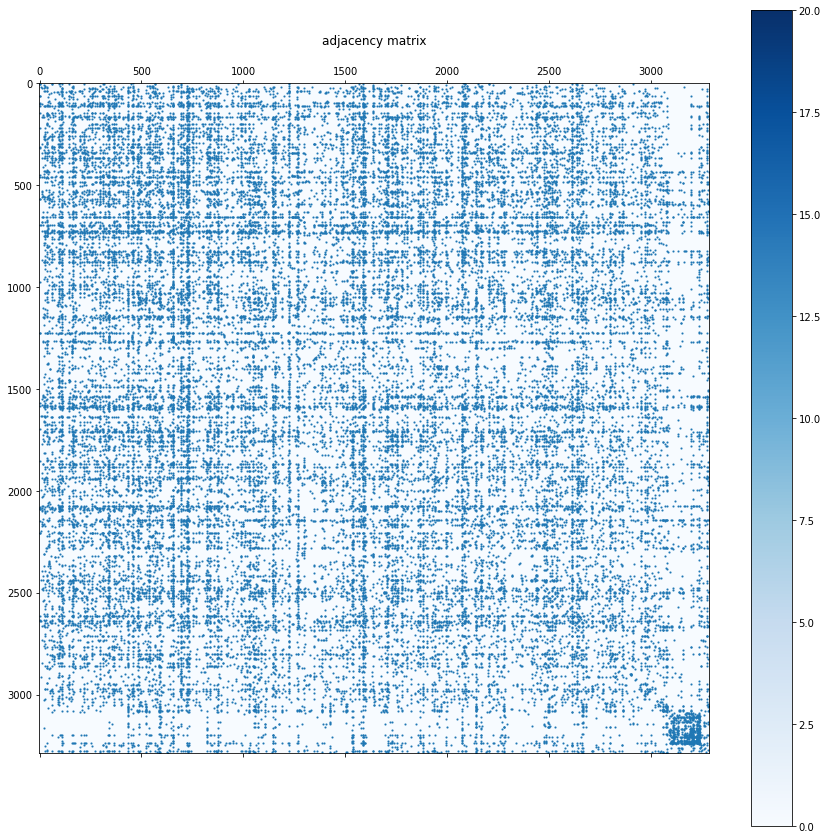

In [44]:
#plot the adjacency matrix
#(SOLVED)Warning: this plot does not show the weights of every links
fig, ax = plt.subplots(figsize = (15, 15))
im = ax.imshow(adj_matrix, cmap=plt.cm.Blues);
fig.colorbar(im)
ax.spy(adj_matrix, markersize=1)
ax.set_title('adjacency matrix')

## 1 - 5: WANG Yunbei

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [20]:
L_max = n_nodes * (n_nodes - 1) / 2
L = np.sum(adjacency);
print(L_max)
print(L)

5400541.0
66511.0


**Your answer here.**

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Your answer here.**

In [20]:
# convert directed graph to undirected one
undig = adjacency.T + adjacency
print(undig)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [22]:
route_active.to_csv('route_active.csv')
np.save('symm_adj_matrix', undig)

### Question 4

Are the edges of your graph weighted?

**Your answer here.** Yes, weighted

### Question 5

What is the degree distibution of your network? 

In [23]:
degree = np.sum(undig, axis = 0)  
# Your code here. It should be a numpy array.

assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

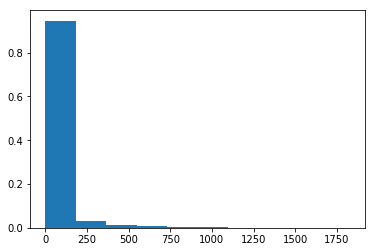

In [24]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [25]:
# Your code here.
aver_degree = np.sum(degree) / n_nodes
print(aver_degree)

40.469120778825676


## 6 - 8: FU Yan

### Question 6

Comment on the degree distribution of your network.

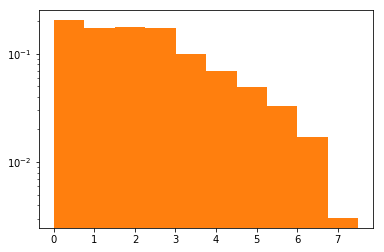

In [26]:
plt.hist(np.log(degree), bins = 10, weights=weights); # apply log-scale to degree
patches = plt.hist(np.log(degree), bins = 10, weights=weights, log = True);

In [27]:
y = patches[0][1:10]
x = patches[1]
bias = np.ones((10,1))
x = x[:10].reshape(10,1)
x = np.hstack((bias,x))[1:10] # add bias term to the mode

In [28]:
gamma = np.linalg.inv(x.T @ x) @ x.T @ y # use least-square to find slope and intersection which fits the graph
print(gamma)

[ 0.21307001 -0.03321182]


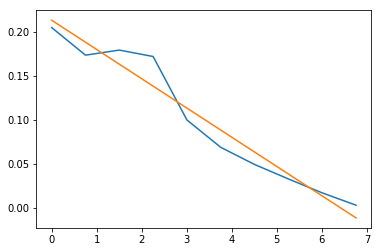

In [29]:
dis_degree = patches[0]
log_degree = patches[1][0:10]
plt.plot(log_degree,dis_degree) # plot the origin distribution, the blue line
plt.plot(log_degree,-0.03321182 * log_degree + 0.21307001) # plot the estimation of distribution

**Your answer here:**

More than 90% nodes with a degree smaller than 250, which means most nodes only connect with a few nodes.
The distribution of degree is similar to the scale-free network, with gamma smaller than 2. This situation happens when the network has multi-links, which corresponds to our flight-route network.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [21]:
def matrix_to_list(matrix):
    """
    Convert np.array to list/dictionary.
    """
    graph = {}
    for i, node in enumerate(matrix):
        adj = []
        for j, connected in enumerate(node):
            if connected:
                adj.append(j)
        graph[i] = adj
    return graph

In [22]:
def connected_graph(adjacency,*arg):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    # Your code here.
    explored = []
    # keep track of nodes to be checked
    if len(arg)==1:
        queue = [arg[0]]
    else:
        queue = [0]
    # keep looping until there are nodes still to be checked
    while queue:
        # pop shallowest first node from queue
        node = queue.pop(0)
        if node not in explored:
            # add node to list of checked nodes
            explored.append(node)
            neighbours = adjacency[node]
            # add neighbours of node to queue
            for neighbour in neighbours:
                queue.append(neighbour)
    if len(explored) < len(adjacency):
        connected = False
    else:
        connected = True
    
    if len(arg)==1:
        return explored
    else:
        return connected

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [63]:
# Your code here.
adj_matrix = (adj_matrix+adj_matrix.T)/2
adj_matrix[adj_matrix>0] = 1
adjmatrix = matrix_to_list(adj_matrix)
connected_graph(adjmatrix)

False

### Question 8

Write a function that extracts the connected components of a graph.

In [151]:
def find_components(adj_matrix):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    components: list of node indices
        A list of indices of connected nodes, one per connected component.
        
    matrix: list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Your code here.
    dict_adj = matrix_to_list(adj_matrix)
    idx_comp = list(range(len(adj_matrix)))
    bfs = []
    
    graphidx = list(set(idx_comp).difference(set(bfs)))
    graphnext = dict_adj
    start_node = graphidx[np.random.randint(0,len(graphidx))]
    components = []
    
    while graphnext:
        bfs = connected_graph(graphnext,start_node)
        components.append(bfs)
        graphidx = list(set(graphidx).difference(set(bfs)))
        if graphidx:
            start_node = graphidx[np.random.randint(0,len(graphidx))]
            graphnext = {key: value for key, value in graphnext.items() if key in graphidx}
        else:
            graphnext = 0
            
    matrix = []
    for j in range(len(components)):
        tmp = np.zeros(adj_matrix.shape)
        for i in components[j]:
            tmp[i,components[j]] = adj_matrix[i,components[j]]
        matrix.append(tmp)

    return components,matrix

In [155]:
# Your code here.
components,matrix = find_components(adj_matrix)
# 'components' contains the index of nodes in each component
# 'matrix' contains the adjacency matrices of each component

In [153]:
len(components)

8

In [159]:
len(max(components,key=len))

3259

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

**ANSWER**

There are 8 components in our network.
The size of largest component is 3259.

## 9 - 10: FENG Wentao

### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [35]:
binary_adj = adj_matrix.T + adj_matrix
binary_adj[binary_adj > 1] = 1 #Generate masked matrix(binary matrix)

def compute_shortest_path_lengths(adj_matrix, source_node):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    
    # Your code here.
    dist_matrix = np.copy(adj_matrix[source_node, :])
    dist_matrix[source_node] = -1
    for i in range(adj_matrix.shape[0]):
        non_zero_idx = np.where(dist_matrix == i + 1)[0]
        zero_idx = np.where(dist_matrix == 0)[0]
        next_neighbor = adj_matrix[non_zero_idx, :]
        if next_neighbor[:, zero_idx].any() == 0:
            break
        next_neighbor = np.sum(next_neighbor[:, zero_idx], axis = 0)
        next_neighbor[np.where(next_neighbor > 0)] = 1 * (i + 2)
        dist_matrix[zero_idx] = next_neighbor
    dist_matrix[dist_matrix == 0] = -1 * np.inf
    dist_matrix[source_node] = 0
    return list(dist_matrix)

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [36]:
def compute_diameter(adj_matrix):
    dist_matrix = np.zeros(adj_matrix.shape)
    for source_node in range(adj_matrix.shape[0]):
        dist_ = np.c_[dist_matrix[0:source_node + 1, source_node].reshape(1, source_node + 1), adj_matrix[source_node, source_node + 1:].reshape(1, 3286 - source_node)][0]
        dist_[source_node] = -1
        for i in range(adj_matrix.shape[0]):
            non_zero_idx = np.where(dist_ == i + 1)[0]
            zero_idx = np.where(dist_ == 0)[0]
            next_neighbor = adj_matrix[non_zero_idx, :]
            if next_neighbor[:, zero_idx].any() == 0:
                dist_matrix[source_node,:] = dist_
                break
            next_neighbor = np.sum(next_neighbor[:, zero_idx], axis = 0)
            next_neighbor[np.where(next_neighbor > 0)] = 1 * (i + 2)
            dist_[zero_idx] = next_neighbor
            
    return np.max(dist_matrix)

## 11 - 13: SUN Zhaodong

### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [37]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    
    # Your code here.
    w = adjacency
    for i in range(length-1):
        w = w.dot(adjacency) # get the number of paths by adjacency matrix multiplication
    n_paths =  w[source, target] # get the number of paths between source and target
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [38]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

0.0
0.0
3.0
0.0
21.0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [39]:
# Your code here.
w = adjacency
for i in range(2):
    w = w.dot(adjacency)
np.sum(w)

1817128777.0

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [40]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    # Your code here.
    # The adjacency should be a masked binary adjacency 
    t = adjacency[node, :] # obtain the row corresponding to the node
    k = np.sum(t) # calculate the degree of the node
    if k == 0 or k == 1:
        return 0.0 
    ind = np.where(t==1)[0]
    adjacency = adjacency[ind,:]
    adjacency = adjacency[:, ind] # slice the adjacency matrix to get the matrix only containing the neighbors of the node
    l = np.sum(adjacency) / 2 # the number of links between the neighbors of the node
    clustering_coefficient = 2 * l / (k * (k - 1))
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [41]:
# Your code here.
length_c = [len(x) for x in components]
max_index = np.argmax(length_c)
largest_com_index = components[max_index]
largest_com = adjacency[largest_com_index, :]
largest_com = largest_com[:, largest_com_index] # get the adjacency matrix only containing the largest component

un_adj = largest_com + largest_com.transpose()
un_adj = (un_adj > 0) # convert to undirected binary adjacency matrix

cc = 0
for i in range(un_adj.shape[0]):
    cc += compute_clustering_coefficient(un_adj, i)
print(cc / un_adj.shape[0])

0.4854619753591008
